In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adamax
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K

### 데이터 생성

In [2]:
train = pd.read_csv('/Users/bdlab/Desktop/sparse-matrix-multiplication/scenario-extraction/d-optimal/spmm-latency-traintest/train-test-csv/nonsquare-train-1035-from-spmm-contain-todense-over-3s-1293.csv')
test = pd.read_csv('/Users/bdlab/Desktop/sparse-matrix-multiplication/scenario-extraction/d-optimal/spmm-latency-traintest/train-test-csv/nonsquare-test-258-from-spmm-contain-todense-over-3s-1293.csv')

In [3]:
# Train
X_train = train[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc' ,
                 'lr*lc*rc', 'ld*rd', 'lr*rc*ld*rd', 'lr*lc*rc*ld*rd']]
y_train = train['bz_smsm']

# Test
X_test = test[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc' ,
                 'lr*lc*rc', 'ld*rd', 'lr*rc*ld*rd', 'lr*lc*rc*ld*rd']]
y_test = test['bz_smsm']

### 데이터 전처리

In [4]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
minmax_scaler = MinMaxScaler()

# 훈련데이터의 모수 분포 저장
minmax_scaler.fit(X_train)

# 훈련 데이터 스케일링
X_train = minmax_scaler.transform(X_train)

# 테스트 데이터 스케일링
X_test = minmax_scaler.transform(X_test)

### Metric 함수 생성

In [5]:
# RMSE
def rmse(y_true, y_pred):
    rmse = K.sqrt(K.mean(K.square(y_pred - y_true))) 
    return rmse

In [6]:
# MAPE
def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

### Hyperparameter 정의

In [7]:
# # dense_nparams : 초기 dense layer size
# dense_nparams = [1024]
# # dense_layer_sizes : 사용할 dense layer size 목록
# dense_layer_sizes = [(256,64,16,)]
# # input_optimizer = optimizer
# input_optimizer = [SGD, Adagrad, RMSprop, Adam, Adamax]
# # input_kernel_initializer : 가중치 초기화 방법
# input_kernel_initializer =  ['uniform', 'normal', 
#                             'glorot_uniform', 'glorot_normal',
#                             'he_uniform', 'he_normal' ]
# # input_dropout : dropout 비율
# input_dropout = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
# # input_lr : learning_rate
# input_lr = [0.001, 0.01, 0.1, 0.2]

# # hyperparameter dictionary 화
# param_grid = dict(dense_nparams = dense_nparams,
#                 dense_layer_sizes = dense_layer_sizes,
#                 input_optimizer = input_optimizer,
#                 input_kernel_initializer = input_kernel_initializer,
#                 input_dropout = input_dropout,
#                 input_lr = input_lr)

In [8]:
# # dense_nparams : 초기 dense layer size
# dense_nparams = [512]
# # dense_layer_sizes : 사용할 dense layer size 목록
# dense_layer_sizes = [(256,128,64,32,)]
# # input_optimizer = optimizer
# input_optimizer = [SGD, Adagrad, RMSprop, Adam, Adamax]
# # input_kernel_initializer : 가중치 초기화 방법
# input_kernel_initializer =  ['he_uniform', 'he_normal']
# # input_dropout : dropout 비율
# input_dropout = [0, 0.1]
# # input_lr : learning_rate
# input_lr = [0.001, 0.01, 0.1]

# # hyperparameter dictionary 화
# param_grid = dict(dense_nparams = dense_nparams,
#                 dense_layer_sizes = dense_layer_sizes,
#                 input_optimizer = input_optimizer,
#                 input_kernel_initializer = input_kernel_initializer,
#                 input_dropout = input_dropout,
#                 input_lr = input_lr)

### Hyperparameter Tuning 대상 정의

In [9]:
# hyperparameter tuning 대상 모델 정의
def create_model(dense_nparams, dense_layer_sizes , input_optimizer, input_kernel_initializer, input_dropout, input_lr):

    model=Sequential()
    model.add(Dense(dense_nparams, activation="relu", input_shape=(X_train.shape[1],), kernel_initializer=input_kernel_initializer))  
    model.add(Dropout(input_dropout),)
    
    # dense_layer_sizes 만큼 layer 추가
    for layer_size in dense_layer_sizes:
        model.add(Dense(layer_size, activation='relu', kernel_initializer=input_kernel_initializer))
        model.add(Dropout(input_dropout), )
    
    model.add(Dense(1))

    optimizer = input_optimizer(lr=input_lr)
    
    model.compile(optimizer = optimizer ,
                  loss='mape',
                  metrics=['mape',rmse])
    return model

# hyperparameter tuning 대상 모델 선언
# 파라미터 조합 당 epochs 는 400 번
regressor_model = KerasRegressor(build_fn=create_model, epochs=400, batch_size=10, verbose=0)

### GridSearchCV 정의 및 시작

In [10]:
# # cross_validation 정의
# kf = KFold(random_state=30,
#            n_splits=10, # Fold 는 10개로 지정
#            shuffle=True
#           )

# # gridsearch 정의
# # scoring : 검증셋의 성능을 무엇으로 측정할 것인지
# # n_jobs : 프로세스가 시스템의 모든 코어를 사용하도록    
# # verbose : 모든 log 출력하도록
# grid = GridSearchCV(estimator=regressor_model, 
#                     param_grid=param_grid, 
#                     scoring = make_scorer(mean_absolute_percentage_error, greater_is_better=False),
#                     cv = kf,
#                     n_jobs=-1,
#                     verbose=3)

# # gridsearch 시작
# grid_result = grid.fit(X_train, y_train)

# # gridesearch 결과
# print("최고의 파라미터 :", grid_result.best_params_)
# print("최고 평균 정확도 : {}".format(grid_result.best_score_))

### GridSearchCV 를 통해 탐색된 최적의 Hyperparameter 를 사용해 모델링

In [11]:
# # 모델 정의
# result_model = create_model(grid_result.best_params_['dense_nparams'],
#                             grid_result.best_params_['dense_layer_sizes'],
#                             grid_result.best_params_['input_optimizer'],
#                             grid_result.best_params_['input_kernel_initializer'],
#                             grid_result.best_params_['input_dropout'],
#                             grid_result.best_params_['input_lr'])
# # 모델 훈련
# history = result_model.fit(X_train, 
#                 y_train,
#                 epochs=400, 
#                 validation_split = 0.1, 
#                 verbose =0)

In [12]:
# hist = pd.DataFrame(history.history)
# hist['epoch'] = history.epoch
# hist.tail()

In [13]:
# def plot_history(history):
#     hist = pd.DataFrame(history.history)
#     hist['epoch'] = history.epoch

#     plt.figure(figsize=(8,12))

#     # mape metric
#     plt.subplot(2,1,1)
#     plt.xlabel('Epoch')
#     plt.ylabel('mape')
#     plt.plot(hist['epoch'], hist['mape'],
#            label='Train Error')
#     plt.plot(hist['epoch'], hist['val_mape'],
#            label = 'Val Error')
#     plt.legend()
    
#     # rmse metric
#     plt.subplot(2,1,2)
#     plt.xlabel('Epoch')
#     plt.ylabel('rmse')
#     plt.plot(hist['epoch'], hist['rmse'],
#            label='Train Error')
#     plt.plot(hist['epoch'], hist['val_rmse'],
#            label = 'Val Error')
#     plt.legend()

#     plt.show()

# plot_history(history)

### 예측 성능

In [14]:
# # 훈련데이터 예측
# y_train_pred = result_model.predict(X_train).reshape(-1,)
# print("훈련데이터 예측 mape : {}\n".format(mean_absolute_percentage_error(y_train,y_train_pred)))

# # 테스트데이터 예측
# y_test_pred = result_model.predict(X_test).reshape(-1,)
# print("테스트데이터 예측 mape : {}\n".format(mean_absolute_percentage_error(y_test,y_test_pred)))

### 고정된 Hyperparameter 를 사용해 모델링 (Early Stopping)

In [15]:
# 모델 정의
fix_model = create_model(1024,
                            (128, 64, 32, 16),
                            Adagrad,
                            'normal',
                            0,
                            0.07)

# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        #print("epoch : {}, logs : {}".format(epoch,logs))
        print('.', end='')

# monitor는 어떤 매개변수를 볼 것인지 입니다.
# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
# 지정된 에포크 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈춥니다.
early_stop = keras.callbacks.EarlyStopping(monitor='val_mape', patience=100)

EPOCHS = 1000

# 훈련 정확도와 검증 정확도 출력
# 에포크마다 훈련 상태를 점검하기 위해 EarlyStopping 콜백(callback)을 사용합니다.
history = fix_model.fit(X_train, 
                    y_train,
                    epochs=EPOCHS, 
                    validation_split = 0.1, 
                    verbose =0, 
                    callbacks=[early_stop, PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....

In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mape,rmse,val_loss,val_mape,val_rmse,epoch
699,3.730693,3.730693,6029.252441,19.063643,19.063643,11755.371094,699
700,3.962609,3.962609,5984.676758,14.067769,14.067769,12342.231445,700
701,4.249284,4.249284,5997.303223,14.102724,14.102724,12164.305664,701
702,3.759036,3.759036,5648.421875,14.981934,14.981934,12281.631836,702
703,4.029417,4.029417,5992.310547,14.158296,14.158296,13732.601562,703


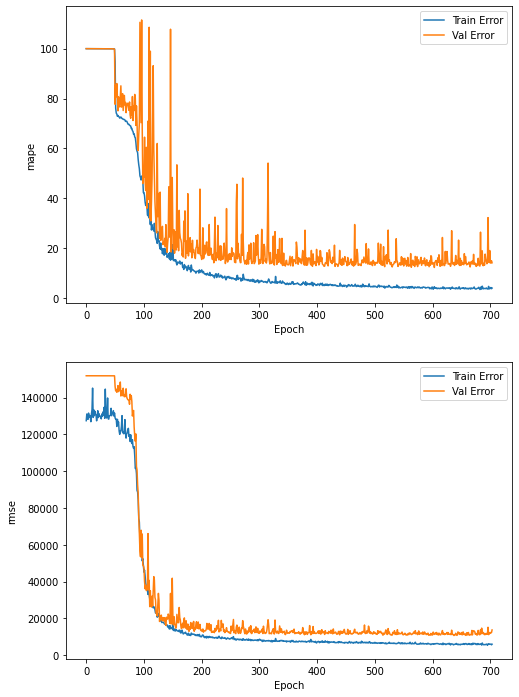

In [17]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    # mape metric
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('mape')
    plt.plot(hist['epoch'], hist['mape'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mape'],
           label = 'Val Error')
    plt.legend()
    
    # rmse metric
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('rmse')
    plt.plot(hist['epoch'], hist['rmse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_rmse'],
           label = 'Val Error')
    plt.legend()

    plt.show()
    
plot_history(history)

In [18]:
# 훈련데이터 예측
y_train_pred = fix_model.predict(X_train).reshape(-1,)
print("훈련데이터 예측 mape : {}\n".format(mean_absolute_percentage_error(y_train,y_train_pred)))

# 테스트데이터 예측
y_test_pred = fix_model.predict(X_test).reshape(-1,)
print("테스트데이터 예측 mape : {}\n".format(mean_absolute_percentage_error(y_test,y_test_pred)))

훈련데이터 예측 mape : 9.560000525685206

테스트데이터 예측 mape : 13.246191332652044



In [19]:
from sklearn.inspection import permutation_importance # sklearn 22 버전부터 해당
from sklearn.metrics import make_scorer

# MAPE
def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# fix_model : 훈련된 모델
# X_train : 훈련데이터 Feature
# y_train : 훈련데이터 Target
# scoring : Feature 를 Shuffler 한 뒤, 예측값과 실제값을 어떤 Metric 을 사용해 비교할지
# n_repeats : 특정 Feature 를 몇번 Shuffle 할 것인지
# random_state : 난수 고정
result = permutation_importance(fix_model, X_train, y_train, scoring = make_scorer(mean_absolute_percentage_error,greater_is_better=False),
                            n_repeats=20,
                            random_state=0)
# Feature label
Feature = train[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc' ,
                 'lr*lc*rc', 'ld*rd', 'lr*rc*ld*rd', 'lr*lc*rc*ld*rd']] 

# Feature 중요도를 오름차순으로 정렬한 뒤, 해당 Feature 의 index 를 저장
sorted_result = result.importances_mean.argsort()

# 결과를 DataFrame 화
importances = pd.DataFrame(result.importances_mean[sorted_result], index=Feature.columns[sorted_result]).sort_values(0, ascending=False)   
importances

,0
ld,39.190555
lnnz,31.916457
ld*rd,23.000013
rnnz,21.527500
lr*lc*rc*ld*rd,18.678413
lr*rc*ld*rd,15.439523
lc,6.371876
rd,4.009139
rc,3.920538
lc*rc,3.651774
